<a href="https://colab.research.google.com/github/feregui00124221/FacialExpression_EmotionsPredictor_CNN/blob/main/AIproject_CNN_(2)(3)_(6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RED NEURONAL CONVOLUCIONAL - PREDICCIÓN DE EXPRESIONES FACIALES

## TODO: Agregar descripción del dataset

## Importación de datos

### Importación de la biblioteca de descarga del dataset de expresiones faciales

In [ ]:
%pip install numpy matplotlib pandas kagglehub opencv-python seaborn scikit-learn tensorflow

### Importación de librerías para el código

In [ ]:
import os   # type: ignore
import shutil # type: ignore
import math # type: ignore
from collections import Counter # type: ignore
import random   # type: ignore
import json # type: ignore
import numpy as np  # type: ignore
import pandas as pd # type: ignore
import seaborn as sns   # type: ignore
import kagglehub    # type: ignore
import matplotlib.pyplot as plt # type: ignore
import cv2  # type: ignore
import tensorflow as tf # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, EfficientNetB1, EfficientNetB3, ResNet50 # type: ignore
from tensorflow.keras.regularizers import l2  # type: ignore
from tensorflow.keras.models import Sequential, Model, load_model # type: ignore
from tensorflow.keras.layers import ReLU, Add, MultiHeadAttention, Layer, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D, Multiply, LeakyReLU # type: ignore
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint  # type: ignore
from tensorflow.keras.optimizers import Adam, SGD  # type: ignore
from tensorflow.keras.activations import swish  # type: ignore
from tensorflow.keras.optimizers.schedules import LearningRateSchedule, CosineDecayRestarts, CosineDecay  # type: ignore
from keras.saving import register_keras_serializable  # type: ignore
from sklearn.metrics import classification_report, confusion_matrix # type: ignore
from sklearn.utils.class_weight import compute_class_weight # type: ignore
from sklearn.metrics import precision_score, recall_score, f1_score # type: ignore

In [ ]:
print("Universidad Iberoamericana - Puebla")
print("--------------------------------------------------------")
print("MODELO DE PREDICCIÓN DE EMOCIONES EN IMÁGENES FACIALES")
print("--------------------------------------------------------")
print("Proyecto final de la asignatura de Agentes Inteligentes")
print("Curso: Agentes Inteligentes")
print("Profesor: Ing. Rafael Pérez Aguirre")
print("--------------------------------------------------------")
print("Integrantes:")
print("Eguizábal Medrano, Fernando Andrés")
print("Gómez Campos, Carlos Alejandro")
print("--------------------------------------------------------")

Universidad Iberoamericana - Puebla
--------------------------------------------------------
MODELO DE PREDICCIÓN DE EMOCIONES EN IMÁGENES FACIALES
--------------------------------------------------------
Proyecto final de la asignatura de Agentes Inteligentes
Curso: Agentes Inteligentes
Profesor: Ing. Rafael Pérez Aguirre
--------------------------------------------------------
Integrantes:
Eguizábal Medrano, Fernando Andrés
Gómez Campos, Carlos Alejandro
--------------------------------------------------------


### Importación del dataset al entorno local

In [ ]:
print("Verificación inicial de archivos...")

shutil.rmtree("./sample_data", ignore_errors=True)

# Ruta donde se almacenará el dataset de AffectNet en el entorno local
dataset_local_path = "./dataset"
os.makedirs(dataset_local_path, exist_ok=True)

# Crear carpeta para almacenar el dataset descargado y sin procesar en el entorno local
raw_download_dataset_path = os.path.join(dataset_local_path, "raw_download")
os.makedirs(raw_download_dataset_path, exist_ok=True)

# Verificar si el dataset ya ha sido descargado
if os.path.exists(dataset_local_path) and os.path.exists(raw_download_dataset_path) and len(os.listdir(raw_download_dataset_path)) > 0:
    print("El dataset ya ha sido descargado y organizado en el entorno local.")
    print(f"Locación de los archivos en {dataset_local_path}")
    print("Proceso de descarga y organización finalizado.")
else:
    print("Descargando dataset...")

    # Ruta donde se descargará el dataset de AffectNet
    dataset_donwload_path = kagglehub.dataset_download("noamsegal/affectnet-training-data")

    print(f"El dataset ha sido descargado exitosamente en {dataset_donwload_path}")

    print("Creación de carpetas para copia de archivos al entorno local...")

    print("¡Entorno local creado! Comenzando migración de datos...")

    # Move the contents of the source folder

    for item in os.listdir(dataset_donwload_path):
        if item in ["contempt", "disgust", "fear", "labels.csv"]:
            continue
        print(f"Migrando directorio {item}...")
        shutil.copytree(os.path.join(dataset_donwload_path, item), os.path.join(raw_download_dataset_path, item))
        print(f"Directorio {item} migrado exitosamente!")

    print(f"Contenido del dataset descargado migrado hacia la carpeta {raw_download_dataset_path}")

    print("Eliminación de carpeta caché de descarga...")

    # Eliminar el dataset descargado
    shutil.rmtree("/root/.cache/kagglehub", ignore_errors=True)

    print(f"Dataset temporal contenido en cache eliminado exitosamente")

Verificación inicial de archivos...
El dataset ya ha sido descargado y organizado en el entorno local.
Locación de los archivos en ./dataset
Proceso de descarga y organización finalizado.


### Ordenado del dataset

In [ ]:
print("Ordenado de la estructura de carpetas...")

train_path = os.path.join(dataset_local_path, "train")
os.makedirs(train_path, exist_ok=True)

test_path = os.path.join(dataset_local_path, "test")
os.makedirs(test_path, exist_ok=True)

if len(os.listdir(train_path)) > 0 and len(os.listdir(test_path)) > 0:
    print("El dataset ya ha sido organizado en carpetas de entrenamiento y prueba.")
    print(f"Locación de los archivos en {train_path} para entrenamiento y {test_path} para testing.")
    print("Proceso de organización finalizado.")
else:
    print("Procediendo a organizar el dataset...")

    # Iterar sobre las subcarpetas en raw_download (cada emoción)
    for emotion_folder in os.listdir(raw_download_dataset_path):
        print(f"Ordenado de la emoción {emotion_folder}...")

        emotion_raw_download_path = os.path.join(raw_download_dataset_path, emotion_folder)

        # Crear subcarpetas en train y test
        train_emotion_path = os.path.join(train_path, emotion_folder)
        os.makedirs(train_emotion_path, exist_ok=True)

        test_emotion_path = os.path.join(test_path, emotion_folder)
        os.makedirs(test_emotion_path, exist_ok=True)

        if (os.path.isdir(emotion_raw_download_path)):
            # Listar todas las imágenes en la carpeta actual
            images = [img for img in os.listdir(emotion_raw_download_path) if img.endswith(('.jpg', '.png'))]

            # Calcular división 80%-20%
            split_index = int(len(images) * 0.8)
            train_images = images[:split_index]
            test_images = images[split_index:]

            # Copiar imágenes a las carpetas correspondientes
            for img in train_images:
                shutil.copy(os.path.join(emotion_raw_download_path, img), os.path.join(train_emotion_path, img))

            for img in test_images:
                shutil.copy(os.path.join(emotion_raw_download_path, img), os.path.join(test_emotion_path, img))

        print(f"Procesado del directorio de '{emotion_folder}': {len(train_images)} imágenes para train, {len(test_images)} imágenes para test.")

    print("Reorganización completada satisfactoriamente.")

    print(f"Ubicación de los archivos en {train_path} para entrenamiento y {test_path} para testing.")

def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            total_size += os.path.getsize(file_path)  # Add file size
    return total_size

# Convert size to a readable format (e.g., MB)
print(f"Tamaño de folder de entrenamiento: {get_folder_size(train_path) / (1024 * 1024):.2f} MB")

# Convert size to a readable format (e.g., MB)
print(f"Tamaño de folder de entrenamiento: {get_folder_size(test_path) / (1024 * 1024):.2f} MB")

Ordenado de la estructura de carpetas...
El dataset ya ha sido organizado en carpetas de entrenamiento y prueba.
Locación de los archivos en ./dataset/train para entrenamiento y ./dataset/test para testing.
Proceso de organización finalizado.
Tamaño de folder de entrenamiento: 209.83 MB
Tamaño de folder de entrenamiento: 52.30 MB


### Visualización de los datos

Visualizing dataset examples...
Classes found: ['anger', 'sad', 'happy', 'neutral', 'surprise']
Visualizing examples from each class with properties:

Class: anger
Dimensions: 96x96
Amount of channels: 3
File Size (KB): 6.24

Class: sad
Dimensions: 96x96
Amount of channels: 3
File Size (KB): 6.10

Class: happy
Dimensions: 96x96
Amount of channels: 3
File Size (KB): 21.29

Class: neutral
Dimensions: 96x96
Amount of channels: 3
File Size (KB): 17.73

Class: surprise
Dimensions: 96x96
Amount of channels: 3
File Size (KB): 5.33


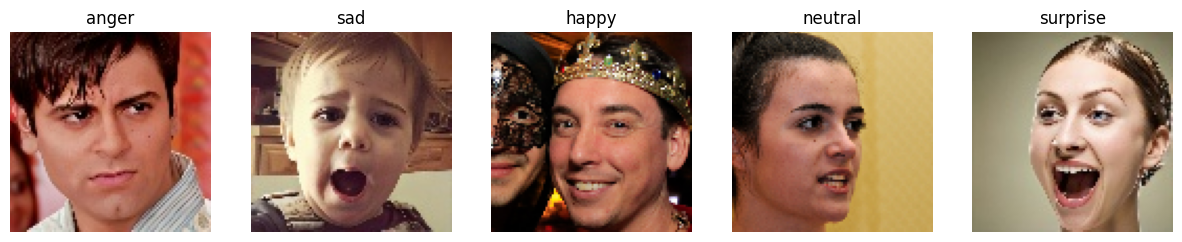

In [ ]:
# Function to describe image properties
def get_image_properties(image_path):
    try:
        image = cv2.imread(image_path)

        if image is None:
            return {"Error": "Could not load image"}

        # Check the number of channels
        if len(image.shape) == 2:
            channels = 1      # Grayscale image
        elif len(image.shape) == 3:
            channels = image.shape[2] # Color image (likely RGB or BGR)
        else:
            channels = "Unknown"

        # Calculate properties based on the original image
        height, width = image.shape[:2]
        size = os.path.getsize(image_path)  # File size in bytes

        return {
            "Dimensions": f"{width}x{height}",
            "Amount of channels": channels,
            "File Size (KB)": f"{size / 1024:.2f}"
        }
    except Exception as e:
        print(f"Error al obtener las propiedades de la imagen: {e}")
        return None

print("Visualizing dataset examples...")

# List available classes
classes = os.listdir(train_path)

print(f"Classes found: {classes}")

print("Visualizing examples from each class with properties:")

# Display an example from each class with properties
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

for i, class_name in enumerate(classes):
    class_folder = os.path.join(train_path, class_name)

    if os.path.isdir(class_folder):
        # Get a random image from the class folder
        files = os.listdir(class_folder)
        random_file = random.choice(files)  # Select a random file from the list
        example_image_path = os.path.join(class_folder, random_file)

        image = cv2.imread(example_image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Display the image
        axes[i].imshow(image_rgb)
        axes[i].axis("off")
        axes[i].set_title(class_name)

        # Get and print image properties
        properties = get_image_properties(example_image_path)

        print(f"\nClass: {class_name}")

        for prop, value in properties.items():
            print(f"{prop}: {value}")
plt.show()

## Preparación de los datos para el entrenamiento

Attributes to be used alongside the model:
Original image size: (96, 96)
Target image size: (96, 96)
Original image channels: 3
Target image channels: 3
Input shape: (96, 96, 3)

Train generator:
Found 13131 images belonging to 5 classes.

Validation generator:
Found 3281 images belonging to 5 classes.

Test generator:
Found 4106 images belonging to 5 classes.

Data augmentation examples:

Batch image shape: (64, 96, 96, 3)
Batch label shape: (64, 5)


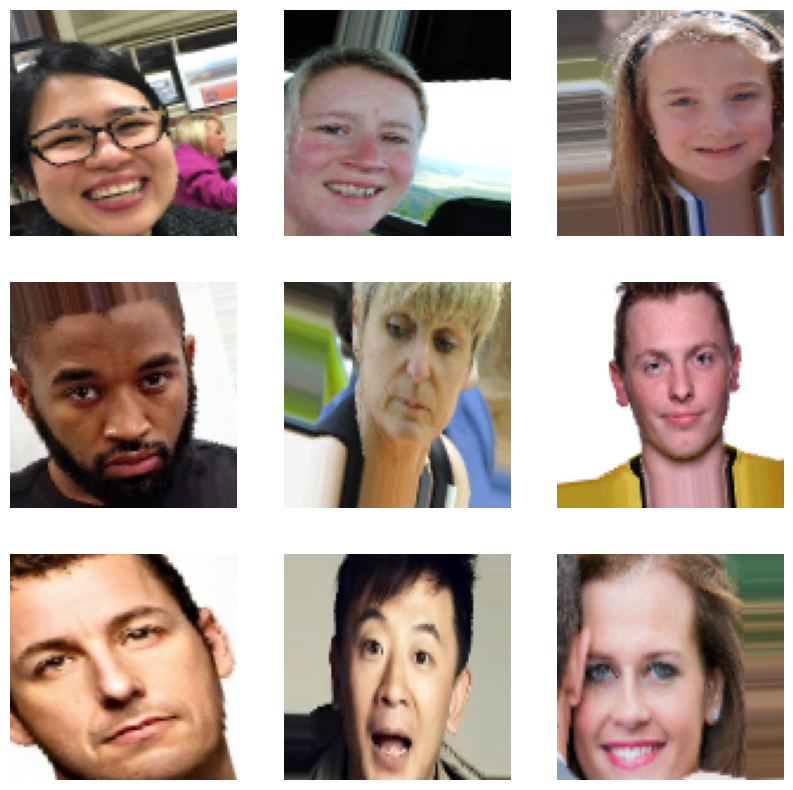

Class anger: 0
Class happy: 1
Class neutral: 2
Class sad: 3
Class surprise: 4
Class anger: 0
Class happy: 1
Class neutral: 2
Class sad: 3
Class surprise: 4
Class anger: 0
Class happy: 1
Class neutral: 2
Class sad: 3
Class surprise: 4


In [ ]:
batch_size=64
assert batch_size > 0, "El tamaño del batch debe ser mayor que 0."

# Obtaining an example of image size and number of channels
sample_class = os.path.join(train_path, classes[random.randint(0, len(classes)-1)])
random_class_choice = random.choice(os.listdir(sample_class))
sample_img_path = os.path.join(sample_class, random_class_choice)
sample_image = cv2.imread(sample_img_path)

original_img_size = sample_image.shape[:2]
target_img_size = (96, 96)  # Target size for the model

img_channels = 1 if len(sample_image.shape) == 2 else sample_image.shape[2]

input_shape = (*target_img_size, img_channels)

print(f"Attributes to be used alongside the model:")

print(f"Original image size: {original_img_size}")
print(f"Target image size: {target_img_size}")
print(f"Original image channels: {len(sample_image.shape)}")
print(f"Target image channels: {img_channels}")
print(f"Input shape: {input_shape}")

data_augmentation = ImageDataGenerator(
    rotation_range=15,             # Augment rotation
    zoom_range=0.3,                # Increase zoom range
    # shear_range=0.2,               # Increase shear
    horizontal_flip=True,          # Flip images
    width_shift_range=0.2,         # Shift width
    height_shift_range=0.2,        # Shift height
    # brightness_range=[0.8, 1.0],   # Narrow brightness range
    # preprocessing_function=None,   # Remove preprocessing function
    rescale=1./255,                # Normalize pixel values
    validation_split=0.2           # Ensure 20% validation split
)

assert os.listdir(train_path), "El directorio de entrenamiento está vacío."
assert os.listdir(test_path), "El directorio de prueba está vacío."

print("\nTrain generator:")

train_generator = data_augmentation.flow_from_directory(
    directory=train_path,
    target_size=target_img_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=42
)

print("\nValidation generator:")
# Validation data generator
validation_generator = data_augmentation.flow_from_directory(
    directory=train_path,
    target_size=target_img_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation",
    shuffle=False,  # No shuffling for validation
    seed=42
)

# Test data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

print("\nTest generator:")
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=target_img_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False
)

# # Define TTA augmentations (be conservative)
# tta_datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     rescale=1./255
# )

print("\nData augmentation examples:")

data_batch, label_batch = next(train_generator)

print(f"\nBatch image shape: {data_batch.shape}")  # Expect (batch_size, 128, 128, 3)
print(f"Batch label shape: {label_batch.shape}")  # Expect (batch_size, num_classes)

plt.figure(figsize=(10, 10))

for i in range(9):  # Show 9 augmented images
    plt.subplot(3, 3, i+1)
    plt.imshow((data_batch[i] * 255).astype("uint8"))
    plt.axis("off")
plt.show()

for index in train_generator.class_indices:
    print(f"Class {index}: {train_generator.class_indices[index]}")

for index in test_generator.class_indices:
    print(f"Class {index}: {test_generator.class_indices[index]}")

for index in validation_generator.class_indices:
    print(f"Class {index}: {validation_generator.class_indices[index]}")

### Verificacion del balance de clases

Verificación del balance de clases...

Diccionario de clases:
Clase 'anger' (índice 0): 2060 muestras
Clase 'happy' (índice 1): 3228 muestras
Clase 'neutral' (índice 2): 3280 muestras
Clase 'sad' (índice 3): 1978 muestras
Clase 'surprise' (índice 4): 2585 muestras


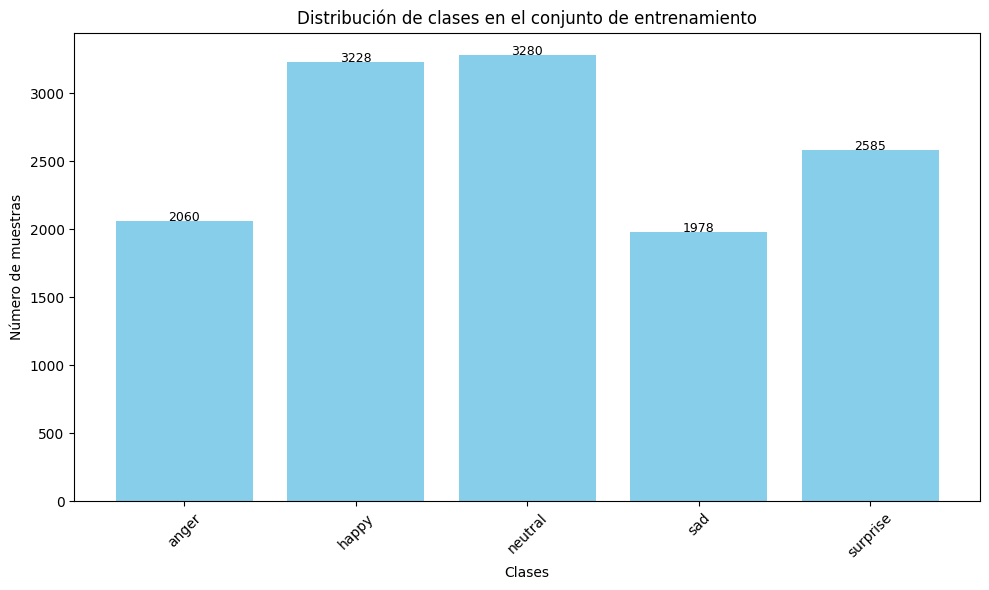


Reporte tabular de la distribución de clases:
      Clase  Cantidad de Muestras
0     anger                  2060
1     happy                  3228
2   neutral                  3280
3       sad                  1978
4  surprise                  2585


In [ ]:
print("Verificación del balance de clases...")

print("\nDiccionario de clases:")
# Obtener el mapeo de índices a nombres de clases
class_indices = train_generator.class_indices  # Diccionario {nombre_clase: índice_clase}
index_to_class = {v: k for k, v in class_indices.items()}  # Invertir el diccionario

# Contar las clases
class_counts = Counter(train_generator.classes)

# Ordenar por índice de clase y mostrar con nombres
for class_index, count in sorted(class_counts.items()):
    class_name = index_to_class[class_index]  # Obtener el nombre asociado al índice
    print(f"Clase '{class_name}' (índice {class_index}): {count} muestras")

# Verificar si hay clases faltantes
expected_classes = set(range(len(class_indices)))
missing_classes = expected_classes - set(class_counts.keys())
if missing_classes:
    missing_class_names = [index_to_class[c] for c in missing_classes if c in index_to_class]
    print(f"Advertencia: Las siguientes clases están vacías: {', '.join(missing_class_names)}")
    raise ValueError(f"Clases faltantes detectadas: {missing_class_names}. Revisa los directorios.")

# Visualización de la distribución
class_names = [index_to_class[i] for i in sorted(class_counts.keys())]
counts = [class_counts[i] for i in sorted(class_counts.keys())]

plt.figure(figsize=(10, 6))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Número de muestras')
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.xticks(rotation=45)
plt.tight_layout()
for i, v in enumerate(counts):
  plt.text(i, v + 0.5, str(v), ha='center', fontsize=9)
plt.show()

# Crear un reporte tabular
df = pd.DataFrame(
    {
    "Clase": class_names,
    "Cantidad de Muestras": counts
    }
)

print("\nReporte tabular de la distribución de clases:")
print(df)

### Cálculo de pesos del desbalance de clases

In [ ]:
num_classes = len(class_counts)  # Number of classes from your dataset

# Identify class indices and counts
total_samples = sum(class_counts)

# Compute class weights using compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Map weights to dictionary
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print(f"Class weights: {class_weights_dict}")

# # Adjust weights for underrepresented classes
# underrepresented_classes = [index for index, count in enumerate(class_counts) if count < total_samples / num_classes]

# # Boost weights for underrepresented classes
# boost_factor = 1.25  # Increase this factor for more emphasis
# for class_index in underrepresented_classes:
#     class_weights_dict[class_index] *= boost_factor

# Optional: Print the adjusted weights for debugging
print("Adjusted class weights:")
for class_index, weight in class_weights_dict.items():
    class_name = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(class_index)]
    print(f"Class: {class_name}, Weight: {weight:.2f}")

# Validar el generador de entrenamiento con pesos
if not train_generator.class_indices or len(train_generator.classes) == 0:
    raise ValueError("El generador no tiene clases o no contiene datos. Verifica la configuración del dataset.")

def balanced_data_generator(generator):
    while True:
        data, labels = generator.next()
        # Find classes with fewer samples
        underrepresented_classes = np.where(labels.sum(axis=0) < np.mean(labels.sum(axis=0)))[0]
        # Duplicate examples from underrepresented classes
        for cls in underrepresented_classes:
            indices = np.where(labels[:, cls] == 1)[0]
            sampled_indices = np.random.choice(indices, size=len(indices) * 2, replace=True)
            data = np.concatenate([data, data[sampled_indices]], axis=0)
            labels = np.concatenate([labels, labels[sampled_indices]], axis=0)
        yield data, labels

train_dataset = tf.data.Dataset.from_generator(
    lambda: ((data, labels) for data, labels in train_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, input_shape[0], input_shape[1], input_shape[2]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: ((data, labels) for data, labels in validation_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, input_shape[0], input_shape[1], input_shape[2]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

# Collect test data into NumPy arrays
test_data = []
test_labels = []

for data, labels in test_generator:
    test_data.append(data)
    test_labels.append(labels)
    if len(test_data) * batch_size >= test_generator.samples:  # Stop after all samples
        break

test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Create a tf.data.Dataset
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_data, test_labels)
    ).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

for data, labels in train_dataset.take(1):
    print(f"\nData shape: {data.shape}, Labels shape: {labels.shape}")

for data, labels in val_dataset.take(1):
    print(f"\nData shape: {data.shape}, Labels shape: {labels.shape}")

for data, labels in test_dataset.take(1):
    print(f"\nData shape: {data.shape}, Labels shape: {labels.shape}")

# def balanced_data_generator(generator):
#     while True:
#         data, labels = next(generator)  # Use `next()` for the generator
#         # Find classes with fewer samples
#         underrepresented_classes = np.where(labels.sum(axis=0) < np.mean(labels.sum(axis=0)))[0]
#         # Duplicate examples from underrepresented classes
#         for cls in underrepresented_classes:
#             indices = np.where(labels[:, cls] == 1)[0]
#             sampled_indices = np.random.choice(indices, size=len(indices) * 2, replace=True)
#             data = np.concatenate([data, data[sampled_indices]], axis=0)
#             labels = np.concatenate([labels, labels[sampled_indices]], axis=0)
#         yield data, labels

Class weights: {0: 1.2748543689320389, 1: 0.8135687732342007, 2: 0.8006707317073171, 3: 1.3277047522750254, 4: 1.0159381044487428}
Adjusted class weights:
Class: anger, Weight: 1.27
Class: happy, Weight: 0.81
Class: neutral, Weight: 0.80
Class: sad, Weight: 1.33
Class: surprise, Weight: 1.02

Data shape: (64, 96, 96, 3), Labels shape: (64, 5)

Data shape: (64, 96, 96, 3), Labels shape: (64, 5)

Data shape: (64, 96, 96, 3), Labels shape: (64, 5)


## Entrenamiento del modelo

### Creación de la arquitectura base del modelo

In [ ]:
# Calculate steps per epoch
steps_per_epoch = math.ceil(train_generator.samples / train_generator.batch_size)
validation_steps = math.ceil(validation_generator.samples / validation_generator.batch_size)
total_epochs = 100  # Total number of training epochs
total_steps = total_epochs * steps_per_epoch

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Number of classes: {num_classes}")

# Define learning rate schedule parameters
initial_lr = 5e-3        # Target LR after warm-up
warmup_lr = 1e-4         # Starting LR
warmup_steps = 10 * steps_per_epoch  # Warm-up for 5 epochs
plateau_steps = 15 * steps_per_epoch  # Plateau for 10 epochs
alpha = 1e-6             # Minimum learning rate factor for cosine decay

base_model = MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )

alpha_holder = {'alpha': [1.0 / num_classes] * num_classes}

@register_keras_serializable(package="Custom", name="AsymmetricLoss")
def asymmetric_loss(y_true, y_pred, gamma_pos=2.0, gamma_neg=4.0):
    pos_loss = -y_true * tf.pow(1 - y_pred, gamma_pos) * tf.math.log(y_pred)
    neg_loss = -(1 - y_true) * tf.pow(y_pred, gamma_neg) * tf.math.log(1 - y_pred)
    return tf.reduce_mean(pos_loss + neg_loss)

@register_keras_serializable(package="Custom", name="AdaptiveFocalLoss")
def adaptive_focal_loss(y_true, y_pred, gamma=2.0):
    """
    Focal Loss with dynamic alpha.
    """
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    alpha = alpha_holder['alpha']  # Dynamically retrieve alpha
    if alpha is not None:
        alpha_tensor = tf.constant(alpha, dtype=tf.float32)
        loss = -y_true * alpha_tensor * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
    else:
        loss = -y_true * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
    return tf.reduce_mean(loss)

@register_keras_serializable(package="Custom", name="HybridLoss")
def hybrid_loss(y_true, y_pred, alpha=0.5, gamma=3.0):
    """
    Combines categorical crossentropy and focal loss.
    Args:
        y_true: True labels.
        y_pred: Predicted probabilities.
        alpha: Weight for the focal loss component.
        gamma: Focusing parameter for focal loss.
    Returns:
        Weighted sum of categorical crossentropy and focal loss.
    """
    # Categorical Crossentropy
    cce_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)

    # Adaptive Focal Loss
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    focal_alpha = alpha_holder['alpha']  # Dynamically retrieve alpha
    if focal_alpha is not None:
        alpha_tensor = tf.constant(focal_alpha, dtype=tf.float32)
        focal_loss = -y_true * alpha_tensor * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
    else:
        focal_loss = -y_true * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
    focal_loss = tf.reduce_mean(focal_loss)

    # Hybrid Loss
    return alpha * focal_loss + (1 - alpha) * cce_loss

@register_keras_serializable(package="Custom", name="DenseResidualBlock")
def dense_residual_block(x, units, dropout_rate=0.4, l2_rate=1e-4):
    shortcut = Dense(units, kernel_regularizer=tf.keras.regularizers.l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dense(units, kernel_regularizer=tf.keras.regularizers.l2(l2_rate), activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    return Add()([x, shortcut])

# def dense_residual_block(x, units, dropout_rate=0.4, l2_rate=1e-4):
#     shortcut = Dense(units, kernel_regularizer=l2(l2_rate))(x)

#     # First dense layer
#     x = BatchNormalization()(x)  # Añadir BatchNormalization para mejorar la convergencia
#     x = Dense(units, kernel_regularizer=tf.keras.regularizers.l2(l2_rate))(x)  # Aumentamos las unidades
#     x = tf.keras.layers.Activation('relu')(x)
#     x = Dropout(dropout_rate)(x)

#     x = Add()([x, shortcut])
#     return x

@register_keras_serializable(package="Custom", name="Transformer")
def transformer_block(x, num_heads=4, key_dim=64):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn_output])  # Skip connection
    x = BatchNormalization()(x)
    x = Dense(key_dim, activation='relu')(x)
    return x


# Update the model
def build_model(input_shape, num_classes, base_model):
    base_model.trainable = False

    for layer in base_model.layers[25:]:
        layer.trainable = True

    inputs = base_model.input_shape

    x = base_model.output

    x = GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Reshape((1, -1))(x)  # Reshape to (batch_size, 1, features)
    x = transformer_block(x)
    x = tf.keras.layers.Reshape((-1,))(x)

    x = dense_residual_block(x, 512, dropout_rate=0.5)
    x = dense_residual_block(x, 128, dropout_rate=0.5)
    # x = dense_residual_block(x, 64, dropout_rate=0.4)
    x = dense_residual_block(x, 32, dropout_rate=0.3)

    # Flatten the tensor before the Dense layer
    x = Flatten()(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    learning_rate = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=1e-4,  # Start lower for stability
        first_decay_steps=steps_per_epoch * 12,
        t_mul=2.0,
        alpha=1e-6
    )

    model = Model(
        inputs=base_model.input,
        outputs=outputs
        )

    model.compile(
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate),
        loss=asymmetric_loss,
        metrics=['accuracy']
    )

    return model

model = build_model(
    input_shape,
    num_classes,
    base_model
    )

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Access the current learning rate from the optimizer
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(epoch * steps_per_epoch)  # Calculate the current LR based on epoch and steps
        print(f"Epoch {epoch + 1}: Learning rate is {lr.numpy():.6f}")

class IncrementalUnfreezeCallback(tf.keras.callbacks.Callback):
    def __init__(self, base_model, unfreeze_schedule):
        super().__init__()
        self.base_model = base_model
        self.unfreeze_schedule = unfreeze_schedule
        self.already_unfrozen = 0  # Track layers already unfrozen

    def on_epoch_end(self, epoch, logs=None):
        if epoch in self.unfreeze_schedule:
            layers_to_unfreeze = self.unfreeze_schedule[epoch]
            new_unfreeze_count = self.already_unfrozen + layers_to_unfreeze

            for layer in self.base_model.layers[-new_unfreeze_count:]:
                layer.trainable = True

            self.already_unfrozen = new_unfreeze_count  # Update unfrozen layers count
            print(f"Epoch {epoch + 1}: Unfroze {layers_to_unfreeze} additional layers.")

unfreeze_schedule = {10: 10, 25: 15}

callbacks = [
    early_stopping,
    model_checkpoint
    # IncrementalUnfreezeCallback(base_model, unfreeze_schedule)
]

Steps per epoch: 206
Validation steps: 52
Number of classes: 5
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 48, 48, 32)     │            864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 48, 48, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 48, 48, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 48, 48, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 48, 48, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 48, 48, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 48, 48, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 48, 48, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 48, 48, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 48, 48, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 48, 48, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 49, 49, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 24, 24, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,866,981 (14.75 MB)

 Trainable params: 3,813,157 (14.55 MB)

 Non-trainable params: 53,824 (210.25 KB)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=total_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

model.save('init_training_cnn_emotions_gomezegui.keras')

with open('init_training_history_gomezegui.json', 'w') as f:
    json.dump(history.history, f)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.2890 - loss: 0.6588
Epoch 1: val_loss improved from inf to 0.43700, saving model to best_model.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 171s 465ms/step - accuracy: 0.2893 - loss: 0.6582 - val_accuracy: 0.4026 - val_loss: 0.4370
Epoch 2/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.4637 - loss: 0.3628
Epoch 2: val_loss did not improve from 0.43700
206/206 ━━━━━━━━━━━━━━━━━━━━ 56s 270ms/step - accuracy: 0.4638 - loss: 0.3626 - val_accuracy: 0.4456 - val_loss: 0.4830
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.5233 - loss: 0.2544
Epoch 3: val_loss did not improve from 0.43700
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 262ms/step - accuracy: 0.5233 - loss: 0.2543 - val_accuracy: 0.5187 - val_loss: 0.6523
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5581 - loss: 0.2036
Epoch 4: val_loss did not improve from 0.43700
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 263ms/step - accuracy: 0.5581 - loss: 0.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# Generate predictions using the test dataset
predictions = model.predict(test_dataset)
predicted_classes = tf.argmax(predictions, axis=1)

In [ ]:
# Extract accuracy and loss values
acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

# Plot accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid()
plt.show()

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Extract true labels from the test dataset
true_labels = tf.concat([y for _, y in test_dataset], axis=0)
true_labels = tf.argmax(true_labels, axis=1).numpy()  # Convert one-hot to integer class

# Generate the classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_classes.numpy(), target_names=list(test_generator.class_indices.keys())))

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes.numpy())

# Print the confusion matrix as text
print("Confusion Matrix (Counts):")
print(cm)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print normalized confusion matrix as text
print("\nNormalized Confusion Matrix:")
np.set_printoptions(precision=2, suppress=True)  # Adjust precision for cleaner output
print(cm_normalized)

# Plot the confusion matrix (Counts)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Calculate metrics
precision = precision_score(true_labels, predicted_classes.numpy(), average='weighted')
recall = recall_score(true_labels, predicted_classes.numpy(), average='weighted')
f1 = f1_score(true_labels, predicted_classes.numpy(), average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# Load the pre-trained model
model = load_model(
    'init_training_cnn_emotions_gomezegui.keras'
    # custom_objects={
    #     # "SpatialAttention": SpatialAttention,
    #     "WarmupCosineDecaySchedule": WarmupCosineDecaySchedule
    # }
)

def focal_loss(gamma=2.0, alpha=[0.4, 0.5, 0.5, 0.6, 0.5]):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        alpha_tensor = tf.constant(alpha, dtype=tf.float32)
        loss = -y_true * alpha_tensor * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
        return tf.reduce_mean(loss)
    return loss_fn

loss_fn = focal_loss()

# Unfreeze additional layers in the base model for fine-tuning
for layer in model.layers[-100:]:  # Unfreeze the last 100 layers
    layer.trainable = True

# Define a lower learning rate with a cosine decay schedule for fine-tuning
fine_tuning_lr = CosineDecay(
    initial_learning_rate=1e-5,  # Lower starting learning rate
    decay_steps=15 * steps_per_epoch,  # Decay over multiple steps
    alpha=1e-6  # Minimum learning rate
)

# Create an optimizer for fine-tuning
fine_tune_optimizer = SGD(learning_rate=fine_tuning_lr, momentum=0.9)

# Recompile the model with the new optimizer
model.compile(
    optimizer=fine_tune_optimizer,
    loss=loss_fn,  # Ensure this matches the initial training loss
    metrics=['accuracy']
)

# Set up callbacks (reuse the ones from the previous training phase or create new ones)
fine_tuning_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'fine_tuned_cnn_emotions_gomezegui.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

fine_tuning_callbacks.append(LearningRateLogger())

In [ ]:
# Fine-tune the model
history_fine_tune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,  # Fine-tuning for additional epochs
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    # class_weight=class_weights_dict,
    callbacks=fine_tuning_callbacks
)

# Save the fine-tuned model
model.save('fine_tuned_cnn_emotions_gomezegui.keras')

with open('fine_training_history_gomezegui.json', 'w') as f:
    json.dump(history_fine_tune.history, f)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# Generate predictions using the test dataset
predictions = model.predict(test_dataset)
predicted_classes = tf.argmax(predictions, axis=1)

In [ ]:
# Extract accuracy and loss values
acc = history_fine_tune.history.get('accuracy', [])
val_acc = history_fine_tune.history.get('val_accuracy', [])
loss = history_fine_tune.history.get('loss', [])
val_loss = history_fine_tune.history.get('val_loss', [])

# Plot accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid()
plt.show()

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Extract true labels from the test dataset
true_labels = tf.concat([y for _, y in test_dataset], axis=0)
true_labels = tf.argmax(true_labels, axis=1).numpy()  # Convert one-hot to integer class

# Generate the classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_classes.numpy(), target_names=list(test_generator.class_indices.keys())))

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes.numpy())

# Print the confusion matrix as text
print("Confusion Matrix (Counts):")
print(cm)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print normalized confusion matrix as text
print("\nNormalized Confusion Matrix:")
np.set_printoptions(precision=2, suppress=True)  # Adjust precision for cleaner output
print(cm_normalized)

# Plot the confusion matrix (Counts)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Calculate metrics
precision = precision_score(true_labels, predicted_classes.numpy(), average='weighted')
recall = recall_score(true_labels, predicted_classes.numpy(), average='weighted')
f1 = f1_score(true_labels, predicted_classes.numpy(), average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")